1. Recap
==

In the last mission, we explored how to use a simple k-nearest neighbors machine learning model that used just one feature, or attribute, of the listing to predict the rent price. We first relied on the <span style="background-color: #F9EBEA; color:##C0392B">accommodates</span> column, which describes the number of people a living space can comfortably accommodate. Then, we switched to the <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span> column and observed an improvement in accuracy. While these were good features to become familiar with the basics of machine learning, it's clear that using just a single feature to compare listings doesn't reflect the reality of the market. An apartment that can accommodate 4 guests in a popular part of Washington D.C. will rent for much higher than one that can accommodate 4 guests in a crime ridden area.

There are 2 ways we can tweak the model to try to improve the accuracy (decrease the RMSE during validation):

- increase the number of attributes the model uses to calculate similarity when ranking the closest neighbors
- increase <span style="background-color: #F9EBEA; color:##C0392B">k</span>, the number of nearby neighbors the model uses when computing the prediction


In this mission, we'll focus on increasing the number of attributes the model uses. When selecting more attributes to use in the model, we need to watch out for columns that don't work well with the distance equation. This includes columns containing:

- non-numerical values (e.g. city or state)
    - Euclidean distance equation expects numerical values
- missing values
    - distance equation expects a value for each observation and attribute
- non-ordinal values (e.g. latitude or longitude)
    - ranking by Euclidean distance doesn't make sense if all attributes aren't ordinal
    
In the following code screen, we've read the <span style="background-color: #F9EBEA; color:##C0392B">dc_airbnb.csv</span> dataset from the last mission into pandas and brought over the data cleaning changes we made. Let's first look at the first row's values to identify any columns containing non-numerical or non-ordinal values. In the next screen, we'll drop those columns and then look for missing values in each of the remaining columns.

<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

**Description**: 

1. Use the <span style="background-color: #F9EBEA; color:##C0392B">DataFrame.info()</span> method to return the number of non-null values in each column.



In [17]:
import pandas as pd
import numpy as np
np.random.seed(1)

dc_listings = pd.read_csv('dc_airbnb.csv')
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')

dc_listings.head(1)

host_response_rate host_acceptance_rate  host_listings_count  \
574               100%                 100%                    1   

     accommodates     room_type  bedrooms  bathrooms  beds  price  \
574             2  Private room       1.0        1.0   1.0  125.0   

    cleaning_fee security_deposit  minimum_nights  maximum_nights  \
574          NaN          $300.00               1               4   

     number_of_reviews   latitude  longitude        city zipcode state  
574                149  38.913548 -77.031981  Washington   20009    DC

2. Removing features
==

The following columns contain non-numerical values:

- <span style="background-color: #F9EBEA; color:##C0392B">room_type</span>: e.g. **Private room**
- <span style="background-color: #F9EBEA; color:##C0392B">city</span>: e.g. **Washington**
- <span style="background-color: #F9EBEA; color:##C0392B">state</span>: e.g. **DC**

while these columns contain numerical but non-ordinal values:

- <span style="background-color: #F9EBEA; color:##C0392B">latitude</span>: e.g. **38.913458**
- <span style="background-color: #F9EBEA; color:##C0392B">longitude</span>: e.g. **-77.031**
- <span style="background-color: #F9EBEA; color:##C0392B">zipcode</span>: e.g. **20009**


Geographic values like these aren't ordinal, because a smaller numerical value doesn't directly correspond to a smaller value in a meaningful way. For example, the zip code 20009 isn't smaller or larger than the zip code 75023 and instead both are unique, identifier values. Latitude and longitude value pairs describe a point on a geographic coordinate system and different equations are used in those cases (e.g. [haversine](https://en.wikipedia.org/wiki/Haversine_formula)).

While we could convert the <span style="background-color: #F9EBEA; color:##C0392B">host_response_rate</span> and <span style="background-color: #F9EBEA; color:##C0392B">host_acceptance_rate</span> columns to be numerical (right now they're object data types and contain the <span style="background-color: #F9EBEA; color:##C0392B">%</span> sign), these columns describe the host and not the living space itself. Since a host could have many living spaces and we don't have enough information to uniquely group living spaces to the hosts themselves, let's avoid using any columns that don't directly describe the living space or the listing itself:

- <span style="background-color: #F9EBEA; color:##C0392B">host_response_rate</span>
- <span style="background-color: #F9EBEA; color:##C0392B">host_acceptance_rate</span>
- <span style="background-color: #F9EBEA; color:##C0392B">host_listings_count</span>

Let's remove these 9 columns from the Dataframe

<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

**Description**: 

1. Remove the 9 columns we discussed above from <span style="background-color: #F9EBEA; color:##C0392B">dc_listings</span>:
    - 3 containing non-numerical values
    - 3 containing numerical but non-ordinal values
    - 3 describing the host instead of the living space itself
2. Verify the number of null values of each remain columns



In [18]:
dc_listings = dc_listings.drop([
    'host_response_rate',
    'host_acceptance_rate',
    'host_listings_count',
    'latitude',
    'longitude',
    'zipcode',
    'room_type',
    'city',
    'state'
], axis=1)
dc_listings.head(1)

accommodates  bedrooms  bathrooms  beds  price cleaning_fee  \
574             2       1.0        1.0   1.0  125.0          NaN   

    security_deposit  minimum_nights  maximum_nights  number_of_reviews  
574          $300.00               1               4                149

3. Handling missing values
==

Of the remaining columns, 3 columns have a few missing values (less than 1% of the total number of rows):

- <span style="background-color: #F9EBEA; color:##C0392B">bedrooms</span>
- <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span>
- <span style="background-color: #F9EBEA; color:##C0392B">beds</span>

Since the number of rows containing missing values for one of these 3 columns is low, we can select and remove those rows without losing much information. There are also 2 columns have a large number of missing values:

- <span style="background-color: #F9EBEA; color:##C0392B">cleaning_fee</span> - 37.3% of the rows
- <span style="background-color: #F9EBEA; color:##C0392B">security_deposit</span> - 61.7% of the rows

and we can't handle these easily. We can't just remove the rows containing missing values for these 2 columns because we'd miss out on the majority of the observations in the dataset. Instead, let's remove these 2 columns entirely from consideration.

<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

**Description**: 

1. Drop the <span style="background-color: #F9EBEA; color:##C0392B">cleaning_fee</span> and <span style="background-color: #F9EBEA; color:##C0392B">security_deposit</span> columns from <span style="background-color: #F9EBEA; color:##C0392B">dc_listings</span>.
2. Then, remove all rows that contain a missing value for the <span style="background-color: #F9EBEA; color:##C0392B">bedrooms</span>, <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span>, or <span style="background-color: #F9EBEA; color:##C0392B">beds</span> column from <span style="background-color: #F9EBEA; color:##C0392B">dc_listings</span>.
    - You can accomplish this by using the [Dataframe method dropna()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html) and setting the <span style="background-color: #F9EBEA; color:##C0392B">axis</span> parameter to **0**.
    - Since only the <span style="background-color: #F9EBEA; color:##C0392B">bedrooms</span>, <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span> and <span style="background-color: #F9EBEA; color:##C0392B">beds</span> columns contain any missing values, rows containing missing values in these columns will be removed.
3. Display the null value counts for the updated <span style="background-color: #F9EBEA; color:##C0392B">dc_listings</span> Dataframe to confirm that there are no missing values left.

In [19]:
dc_listings = dc_listings.drop([
    'cleaning_fee',
    'security_deposit'
], axis=1)

dc_listings = dc_listings.dropna(axis=0)
dc_listings.isnull().sum()

accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64

4. Normalize columns
==

Here's how the <span style="background-color: #F9EBEA; color:##C0392B">dc_listings</span> Dataframe looks like after all the changes we made:

| accommodates | bedrooms | bathrooms | beds | price | minimum_nights | maximum_nights | number_of_reviews |
|--------------|----------|-----------|------|-------|----------------|----------------|-------------------|
| 2            | 1.0      | 1.0       | 1.0  | 125.0 | 1              | 4              | 149               |
| 2            | 1.0      | 1.5       | 1.0  | 85.0  | 1              | 30             | 49                |
| 1            | 1.0      | 0.5       | 1.0  | 50.0  | 1              | 1125           | 1                 |
| 2            | 1.0      | 1.0       | 1.0  | 209.0 | 4              | 730            | 2                 |
| 12           | 5.0      | 2.0       | 5.0  | 215.0 | 2              | 1825           | 34                |

You may have noticed that while the <span style="background-color: #F9EBEA; color:##C0392B">accommodates</span>, <span style="background-color: #F9EBEA; color:##C0392B">bedrooms</span>, <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span>, <span style="background-color: #F9EBEA; color:##C0392B">beds</span>, and <span style="background-color: #F9EBEA; color:##C0392B">minimum_nights</span> columns hover between 0 and 12 (at least in the first few rows), the values in the <span style="background-color: #F9EBEA; color:##C0392B">maximum_nights</span> and <span style="background-color: #F9EBEA; color:##C0392B">number_of_reviews</span> columns span much larger ranges. For example, the <span style="background-color: #F9EBEA; color:##C0392B">maximum_nights</span> column has values as low as 4 and high as 1825, in the first few rows itself. If we use these 2 columns as part of a k-nearest neighbors model, these attributes could end up having an outsized effect on the distance calculations because of the largeness of the values.

For example, 2 living spaces could be identical across every attribute but be vastly different just on the <span style="background-color: #F9EBEA; color:##C0392B">maximum_nights</span> column. If one listing had a <span style="background-color: #F9EBEA; color:##C0392B">maximum_nights</span> value of 1825 and the other a <span style="background-color: #F9EBEA; color:##C0392B">maximum_nights</span> value of 4, because of the way Euclidean distance is calculated, these listings would be considered very far apart because of the outsized effect the largeness of the values had on the overall Euclidean distance. To prevent any single column from having too much of an impact on the distance, we can **normalize** all of the columns to have a mean of 0 and a standard deviation of 1.

Normalizing the values in each columns to the [standard normal distribution](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution) (mean of 0, standard deviation of 1) preserves the distribution of the values in each column while aligning the scales. To normalize the values in a column to the standard normal distribution, you need to:

- from each value, subtract the mean of the column
- divide each value by the standard deviation of the column

Here's the mathematical formula describing the transformation that needs to be applied for all values in a column:

$\displaystyle z= \frac{x − \mu}{\sigma}$

where x is a value in a specific column, $\mu$ is the mean of all the values in the column, and $\sigma$ is the standard deviation of all the values in the column. Here's what the corresponding code, using pandas, looks like:

>```python
# Subtract each value in the column by the mean.
first_transform = dc_listings['maximum_nights'] - dc_listings['maximum_nights'].mean()
# Divide each value in the column by the standard deviation.
normalized_col = first_transform / dc_listings['maximum_nights'].std()
```

To apply this transformation across all of the columns in a Dataframe, you can use the corresponding Dataframe methods mean() and std():

>```python
normalized_listings = (dc_listings - dc_listings.mean()) / (dc_listings.std())
```

These methods were written with mass column transformation in mind and when you call <span style="background-color: #F9EBEA; color:##C0392B">mean()</span> or <span style="background-color: #F9EBEA; color:##C0392B">std()</span>, the appropriate column means and column standard deviations are used for each value in the Dataframe. Let's now normalize all of the feature columns in <span style="background-color: #F9EBEA; color:##C0392B">dc_listings</span>.

<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

**Description**: 

1. Normalize all of the feature columns in <span style="background-color: #F9EBEA; color:##C0392B">dc_listings</span> and assign the new Dataframe containing just the normalized feature columns to <span style="background-color: #F9EBEA; color:##C0392B">normalized_listings</span>.
2. Add the price column from <span style="background-color: #F9EBEA; color:##C0392B">dc_listings</span> to <span style="background-color: #F9EBEA; color:##C0392B">normalized_listings</span>.
3. Display the first 3 rows in <span style="background-color: #F9EBEA; color:##C0392B">normalized_listings</span>.

In [21]:
normalized_listings = (dc_listings - dc_listings.mean()) / (dc_listings.std())
normalized_listings['price'] = dc_listings.price
normalized_listings.head(3)

accommodates  bedrooms  bathrooms      beds  price  minimum_nights  \
574      -0.596544 -0.249467  -0.439151 -0.546858  125.0       -0.341375   
1593     -0.596544 -0.249467   0.412923 -0.546858   85.0       -0.341375   
3091     -1.095499 -0.249467  -1.291226 -0.546858   50.0       -0.341375   

      maximum_nights  number_of_reviews  
574        -0.016604           4.579650  
1593       -0.016603           1.159275  
3091       -0.016573          -0.482505

5. Euclidean distance for multivariate case
==

In the last mission, we trained 2 univariate k-nearest neighbors models. The first one used the <span style="background-color: #F9EBEA; color:##C0392B">accommodates</span> attribute while the second one used the <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span> attribute. Let's now train a model that uses **both** attributes when determining how similar 2 living spaces are. Let's refer to the Euclidean distance equation again to see what the distance calculation using 2 attributes would look like:

$\displaystyle d = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + \ldots + (q_n - p_n)^2}$

Since we're using 2 attributes, the distance calculation would look like:

$\displaystyle d = \sqrt{(accommodates_1 - accomodates_2)^2 + (bathrooms_1 - bathrooms_2)^2}$


To find the distance between 2 living spaces, we need to calculate the squared difference between both <span style="background-color: #F9EBEA; color:##C0392B">accommodates</span> values, the squared difference between both <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span> values, add them together, and then take the square root of the resulting sum. Here's what the Euclidean distance between the first 2 rows in <span style="background-color: #F9EBEA; color:##C0392B">normalized_listings</span> looks like:

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=15uoTMT1rzRLx9T8kIbsOWw7HaTmdBP0o">


So far, we've been calculating Euclidean distance ourselves by writing the logic for the equation ourselves. We can instead use the [distance.euclidean()](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.euclidean.html) function from <span style="background-color: #F9EBEA; color:##C0392B">scipy.spatial</span>, which takes in 2 vectors as the parameters and calculates the Euclidean distance between them. The <span style="background-color: #F9EBEA; color:##C0392B">euclidean()</span> function expects:

- both of the vectors to be represented using a **list-like** object (Python list, NumPy array, or pandas Series)
- both of the vectors must be 1-dimensional and have the same number of elements

Here's a simple example:

>```python
from scipy.spatial import distance
first_listing = [-0.596544, -0.439151]
second_listing = [-0.596544, 0.412923]
dist = distance.euclidean(first_listing, second_listing)
```

Let's use the <span style="background-color: #F9EBEA; color:##C0392B">euclidean()</span> function to calculate the Euclidean distance between 2 rows in our dataset to practice.

<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

**Description**: 

1. Calculate the Euclidean distance using only the <span style="background-color: #F9EBEA; color:##C0392B">accommodates</span> and <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span> features between the first row and fifth row in <span style="background-color: #F9EBEA; color:##C0392B">normalized_listings</span> using the <span style="background-color: #F9EBEA; color:##C0392B">distance.euclidean()</span> function.
2. Assign the distance value to <span style="background-color: #F9EBEA; color:##C0392B">first_fifth_distance</span> and display using the <span style="background-color: #F9EBEA; color:##C0392B">print</span> function.


In [23]:
from scipy.spatial import distance

first_fifth_distance = distance.euclidean(normalized_listings.iloc[0:5].accommodates, normalized_listings.iloc[0:5].bathrooms) 
first_fifth_distance

3.300197080884489

6. Introduction to scikit-learn
==

So far, we've been writing functions from scratch to train the k-nearest neighbor models. While this is helpful deliberate practice to understand how the mechanics work, you can be more productive and iterate quicker by using a library that handles most of the implementation. In this screen, we'll learn about the [scikit-learn library](http://scikit-learn.org/), which is the most popular machine learning in Python. Scikit-learn contains functions for all of the major machine learning algorithms and a simple, unified workflow. Both of these properties allow data scientists to be incredibly productive when training and testing different models on a new dataset.

The scikit-learn workflow consists of 4 main steps:

- instantiate the specific machine learning model you want to use
- fit the model to the training data
- use the model to make predictions
- evaluate the accuracy of the predictions


We'll focus on the first 3 steps in this screen and the next screen. Each model in scikit-learn is implemented as a [separate class](http://scikit-learn.org/dev/modules/classes.html) and the first step is to identify the class we want to create an instance of. In our case, we want to use the [KNeighborsRegressor class](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor).
Any model that helps us predict numerical values, like listing price in our case, is known as a **regression** model. The other main class of machine learning models is called classification, where we're trying to predict a label from a fixed set of labels (e.g. blood type or gender). The word **regressor** from the class name <span style="background-color: #F9EBEA; color:##C0392B">KNeighborsRegressor</span> refers to the regression model class that we just discussed.

Scikit-learn uses a similar object-oriented style to Matplotlib and you need to instantiate an empty model first by calling the constructor:

>```python
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
```

If you refer to the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor), you'll notice that by default:

- <span style="background-color: #F9EBEA; color:##C0392B">n_neighbors:</span> the number of neighbors, is set to **5**
- <span style="background-color: #F9EBEA; color:##C0392B">algorithm:</span> for computing nearest neighbors, is set to **auto**
- <span style="background-color: #F9EBEA; color:##C0392B">p:</span> set to **2**, corresponding to Euclidean distance

Let's set the <span style="background-color: #F9EBEA; color:##C0392B">algorithm</span> parameter to <span style="background-color: #F9EBEA; color:##C0392B">brute</span> and leave the <span style="background-color: #F9EBEA; color:##C0392B">n_neighbors</span> value as **5**, which matches the implementation we wrote in the last mission. If we leave the <span style="background-color: #F9EBEA; color:##C0392B">algorithm</span> parameter set to the default value of <span style="background-color: #F9EBEA; color:##C0392B">auto</span>, scikit-learn will try to use tree-based optimizations to improve performance (which are outside of the scope of this mission):

>```python
knn = KNeighborsRegressor(algorithm='brute')
```


7. Fitting a model and making predictions
==

Now, we can fit the model to the data using the [fit method](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.fit). For all models, the <span style="background-color: #F9EBEA; color:##C0392B">fit</span> method takes in 2 required parameters:

- matrix-like object, containing the feature columns we want to use from the training set.
- list-like object, containing correct target values.

Matrix-like object means that the method is flexible in the input and either a Dataframe or a NumPy 2D array of values is accepted. This means you can select the columns you want to use from the Dataframe and use that as the first parameter to the <span style="background-color: #F9EBEA; color:##C0392B">fit</span> method.

If you recall from earlier in the mission, all of the following are acceptable list-like objects:

- NumPy array
- Python list
- pandas Series object (e.g. when selecting a column)

You can select the target column from the Dataframe and use that as the second parameter to the <span style="background-color: #F9EBEA; color:##C0392B">fit</span> method:

>```python
# Split full dataset into train and test sets.
train_df = normalized_listings.iloc[0:2792]
test_df = normalized_listings.iloc[2792:]
# Matrix-like object, containing just the 2 columns of interest from training set.
train_features = train_df[['accommodates', 'bathrooms']]
# List-like object, containing just the target column, `price`.
train_target = normalized_listings['price']
# Pass everything into the fit method.
knn.fit(train_features, train_target)
```


When the <span style="background-color: #F9EBEA; color:##C0392B">fit</span> method is called, scikit-learn stores the training data we specified within the KNearestNeighbors instance (<span style="background-color: #F9EBEA; color:##C0392B">knn</span>). If you try passing in data containing missing values or non-numerical values into the <span style="background-color: #F9EBEA; color:##C0392B">fit</span> method, scikit-learn will return an error. Scikit-learn contains many such features that help prevent us from making common mistakes.

Now that we specified the training data we want used to make predictions, we can use the [predict method](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.predict) to make predictions on the test set. The <span style="background-color: #F9EBEA; color:##C0392B">predict</span> method has only one required parameter:

- matrix-like object, containing the feature columns from the dataset we want to make predictions on

The number of feature columns you use during both training and testing need to match or scikit-learn will return an error:

>```python
predictions = knn.predict(test_df[['accommodates', 'bathrooms']])
```

The <span style="background-color: #F9EBEA; color:##C0392B">predict()</span> method returns a NumPy array containing the predicted <span style="background-color: #F9EBEA; color:##C0392B">price</span> values for the test set. You now have everything you need to practice the entire scikit-learn workflow.

<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

**Description**: 

1. Create an instance of the [KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) class with the following parameters:
    - <span style="background-color: #F9EBEA; color:##C0392B">n_neighbors</span>: 5
    - <span style="background-color: #F9EBEA; color:##C0392B">algorithm</span>: brute
2. Use the <span style="background-color: #F9EBEA; color:##C0392B">fit</span> method to specify the data we want the k-nearest neighbor model to use. Use the following parameters:
    - training data, feature columns: just the <span style="background-color: #F9EBEA; color:##C0392B">accommodates</span> and <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span> columns, in that order, from <span style="background-color: #F9EBEA; color:##C0392B">train_df</span>.
    - training data, target column: the <span style="background-color: #F9EBEA; color:##C0392B">price</span> column from <span style="background-color: #F9EBEA; color:##C0392B">train_df</span>.
3. Call the <span style="background-color: #F9EBEA; color:##C0392B">predict</span> method to make predictions on:
    - the <span style="background-color: #F9EBEA; color:##C0392B">accommodates</span> and <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span> columns from <span style="background-color: #F9EBEA; color:##C0392B">test_df</span>
    - assign the resulting NumPy array of predicted price values to <span style="background-color: #F9EBEA; color:##C0392B">predictions</span>.

In [26]:
train_target.shape

(3671,)

In [28]:
from sklearn.neighbors import KNeighborsRegressor

train_df = normalized_listings.iloc[0:2792]
test_df = normalized_listings.iloc[2792:]

knn = KNeighborsRegressor(algorithm='brute')

# Matrix-like object, containing just the 2 columns of interest from training set.
train_features = train_df[['accommodates', 'bathrooms']]
# List-like object, containing just the target column, `price`.
train_target = train_df['price']
# Pass everything into the fit method.
knn.fit(train_features, train_target)

predictions = knn.predict(test_df[['accommodates', 'bathrooms']])

8. Calculating MSE using Scikit-Learn
==

Earlier in this mission, we calculated the MSE and RMSE values using the pandas arithmetic operators to compare each predicted value with the actual value from the <span style="background-color: #F9EBEA; color:##C0392B">price</span> column of our test set. Alternatively, we can instead use the [sklearn.metrics.mean_squared_error function()](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error). Once you become familiar with the different machine learning concepts, unifying your workflow using scikit-learn helps save you a lot of time and avoid mistakes.

The <span style="background-color: #F9EBEA; color:##C0392B">mean_squared_error()</span> function takes in 2 inputs:

- list-like object, representing the true values
- list-like object, representing the predicted values using the model

For this function, we won't show any sample code and will leave it to you to understand the function [from the documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) itself to calculate the MSE and RMSE values for the predictions we just made.


<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

**Description**: 

1. Use the <span style="background-color: #F9EBEA; color:##C0392B">mean_squared_error</span> function to calculate the MSE value for the predictions we made in the previous screen.
2. Assign the MSE value to <span style="background-color: #F9EBEA; color:##C0392B">two_features_mse</span>.
3. Calculate the RMSE value by taking the square root of the MSE value and assign to <span style="background-color: #F9EBEA; color:##C0392B">two_features_rmse</span>.
4. Display both of these error scores using the <span style="background-color: #F9EBEA; color:##C0392B">print</span> function.

In [32]:
from sklearn.metrics import mean_squared_error

train_columns = ['accommodates', 'bathrooms']
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean')
knn.fit(train_df[train_columns], train_df['price'])
predictions = knn.predict(test_df[train_columns])

two_features_mse = mean_squared_error(predictions, test_df['price'])
two_features_rmse = np.sqrt(two_features_mse)
print(two_features_mse)
print(two_features_rmse)

15184.425165
123.225099574


9. Using more features
==

Here's a table comparing the MSE and RMSE values for the 2 univariate models from the last mission and the multivariate model we just trained:

| feature(s)              | MSE     | RMSE  |
|-------------------------|---------|-------|
| accommodates            | 18646.5 | 136.6 |
| bathrooms               | 17333.4 | 131.7 |
| accommodates, bathrooms | 15660.4 | 125.1 |

As you can tell, the model we trained using both features ended up performing better (lower error score) than either of the univariate models from the last mission. Let's now train a model using the following 4 features:

- <span style="background-color: #F9EBEA; color:##C0392B">accommodates</span>
- <span style="background-color: #F9EBEA; color:##C0392B">bedrooms</span>
- <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span>
- <span style="background-color: #F9EBEA; color:##C0392B">number_of_reviews</span>

Scikit-learn makes it incredibly easy to swap the columns used during training and testing. We're going to leave this for you as a challenge to train and test a k-nearest neighbors model using these columns instead. Use the code you wrote in the last screen as a guide.

<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

**Description**: 


1. Create a new instance of the [KNeighborsRegressor class](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) with the following parameters:
    - <span style="background-color: #F9EBEA; color:##C0392B">n_neighbors</span>: 5
    - <span style="background-color: #F9EBEA; color:##C0392B">algorithm</span>: brute
2. Fit a model that uses the following columns from our training set (**train_df**):
    - <span style="background-color: #F9EBEA; color:##C0392B">accommodates</span>
    - <span style="background-color: #F9EBEA; color:##C0392B">bedrooms</span>
    - <span style="background-color: #F9EBEA; color:##C0392B">bathrooms</span>
    - <span style="background-color: #F9EBEA; color:##C0392B">number_of_reviews</span>
3. Use the model to make predictions on the test set (**test_df**) using the same columns. Assign the NumPy array of predictions to <span style="background-color: #F9EBEA; color:##C0392B">four_predictions</span>.
4. Use the <span style="background-color: #F9EBEA; color:##C0392B">mean_squared_error()</span> function to calculate the MSE value for these predictions by comparing <span style="background-color: #F9EBEA; color:##C0392B">four_predictions</span> with the price column from **test_df**. Assign the computed MSE value to <span style="background-color: #F9EBEA; color:##C0392B">four_mse</span>.
5. Calculate the RMSE value and assign to <span style="background-color: #F9EBEA; color:##C0392B">four_rmse</span>.
6. Display <span style="background-color: #F9EBEA; color:##C0392B">four_mse</span> and <span style="background-color: #F9EBEA; color:##C0392B">four_rmse</span> using the print function.


In [33]:
train_columns = ['accommodates', 'bathrooms', 'bedrooms', 'number_of_reviews']
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean')
knn.fit(train_df[train_columns], train_df['price'])
four_predictions = knn.predict(test_df[train_columns])

four_features_mse = mean_squared_error(four_predictions, test_df['price'])
four_features_rmse = np.sqrt(four_features_mse)
print(four_features_mse)
print(four_features_rmse)

13474.4033675
116.079297756


10. Using all features
==

So far so good! As we increased the features the model used, we observed lower MSE and RMSE values:

| feature(s)                                           | MSE     | RMSE  |
|------------------------------------------------------|---------|-------|
| accommodates                                         | 18646.5 | 136.6 |
| bathrooms                                            | 17333.4 | 131.7 |
| accommodates, bathrooms                              | 15660.4 | 125.1 |
| accommodates, bathrooms, bedrooms, number_of_reviews | 13320.2 | 115.4 |

Let's take this to the extreme and use all of the potential features. We should expect the error scores to decrease since so far adding more features has helped do so.

<br>
<div class="alert alert-info">
<b>Exercise Start.</b>
</div>

**Description**: 

1. Use all of the columns, except for the <span style="background-color: #F9EBEA; color:##C0392B">price</span> column, to train a k-nearest neighbors model using the same parameters for the <span style="background-color: #F9EBEA; color:##C0392B">KNeighborsRegressor</span> class as the ones from the last few screens.
2. Use the model to make predictions on the test set and assign the resulting NumPy array of predictions to <span style="background-color: #F9EBEA; color:##C0392B">all_features_predictions</span>.
3. Calculate the MSE and RMSE values and assign to <span style="background-color: #F9EBEA; color:##C0392B">all_features_mse</span> and <span style="background-color: #F9EBEA; color:##C0392B">all_features_rmse</span> accordingly.
4. Use the **print** function to display both error scores.

In [34]:
train_df.columns

Index(['accommodates', 'bedrooms', 'bathrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'number_of_reviews'],
      dtype='object')

In [35]:
train_columns = ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews']
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean')
knn.fit(train_df[train_columns], train_df['price'])
all_features_predictions = knn.predict(test_df[train_columns])

all_features_mse = mean_squared_error(all_features_predictions, test_df['price'])
all_features_rmse = np.sqrt(all_features_mse)
print(all_features_mse)
print(all_features_rmse)

15392.6253925
124.067019761


11. Next steps
==

Interestingly enough, the RMSE value actually increased to **125.1** when we used all of the features available to us. This means that selecting the right features is important and that using more features doesn't automatically improve prediction accuracy. We should re-phrase the lever we mentioned earlier from:

- increase the number of attributes the model uses to calculate similarity when ranking the closest neighbors

to:

- select the relevant attributes the model uses to calculate similarity when ranking the closest neighbors

The process of selecting features to use in a model is known as **feature selection**.

In this mission, we prepared the data to be able to use more features, trained a few models using multiple features, and evaluated the different performance tradeoffs. We explored how using more features doesn't always improve the accuracy of a k-nearest neighbors model. In the next mission, we'll explore another knob for tuning k-nearest neighbor models - the k value.

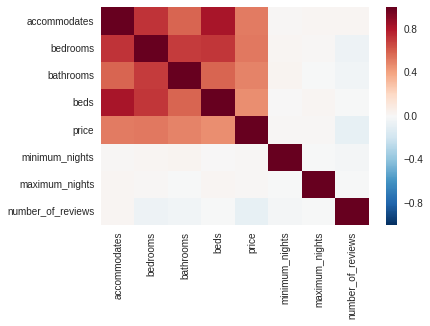

In [39]:
import seaborn as sns
%matplotlib inline
sns.heatmap(dc_listings.corr())

In [50]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
train_columns = ['accommodates', 'bedrooms', 'bathrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews']
rfe = rfe.fit(train_df[train_columns], train_df['price'])
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True False False False False]
[1 1 1 2 4 5 3]


In [51]:
train_columns = ['accommodates', 'bedrooms', 'bathrooms']
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean')
knn.fit(train_df[train_columns], train_df['price'])
all_features_predictions = knn.predict(test_df[train_columns])

all_features_mse = mean_squared_error(all_features_predictions, test_df['price'])
all_features_rmse = np.sqrt(all_features_mse)
print(all_features_mse)
print(all_features_rmse)

13407.8356769
115.792209051
